# Pandeia for WFIRST Imaging

How to cite this code:

> Klaus M. Pontoppidan ; Timothy E. Pickering ; Victoria G. Laidler ; Karoline Gilbert ; Christopher D. Sontag, et al.
"Pandeia: a multi-mission exposure time calculator for JWST and WFIRST", Proc. SPIE 9910, Observatory Operations: Strategies, Processes, and Systems VI, 991016 (July 15, 2016); doi:10.1117/12.2231768; http://dx.doi.org/10.1117/12.2231768

This is an introductory notebook that provides an easy-to-use interface for making Pandeia ETC calculations. The Pandeia engine called by this notebook only supports basic WFIRST imaging, IFU and Grism modes - the coronagraph and coronagraphic IFU spectrograph are not supported. This notebook has simplified some configuration options to present a summary of the steps most users will take to make WFIRST calculations. Users are encouraged to view <a href="https://jwst-docs.stsci.edu/display/JPP/JWST+Exposure+Time+Calculator+-+ETC">the JWST documentation</a> for an overview of the features and functionality of the Pandeia engine and an explanation of the quantities calculated by Pandeia.



Refer to the documentation links provided within the *Help* menu for general information on the Jupyter/IPython notebook interface and useful keyboard short-cuts.  The key things you need to know are that you must use ``Shift-Enter`` to execute a cell and that once a cell is executed, all data defined within it becomes available to all other cells. (You can also click the <i class="fa-step-forward fa"></i> icon in the toolbar to run a cell.)

This first cell sets up the imports and configuration that are required:  

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from __future__ import print_function, division
import sys
import os
import numpy as np
import matplotlib
from matplotlib import style
#style.use('ggplot')  # see http://matplotlib.org/users/style_sheets.html
                     # for info on matplotlib styles
import json
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

# the first pandeia import is required to run calculations. the others are provided to
# allow setting up calculations and loading/saving of inputs or results.
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

To run Pandeia, you must give it a calculation. Calculations are python dictionaries that specify every aspect of the detector configuration, instrument configuration, details of all of the sources in the scene, and observing strategies.

Let's break it down.

# First, we need to create a calculation. 

build_default_calc will create a default calculation for a WFIRST instrument, complete with a single faint point source.

build_default_calc() takes three arguments: telescope, instrument, mode.

Telescope is (obviously) wfirst.

Instrument is either wfirstimager or wfirstifu

The modes available for the WFIRST Imager are the Imager and the Grism; the only mode available for the IFU channel subsystem is the IFU.

To set up default observations for one of these three modes, run one of the three following cells.

### WFIRST Imager

In [34]:
calc = build_default_calc('wfirst','wfirstimager','imager')

### WFIRST Grism

In [2]:
calc = build_default_calc('wfirst','wfirstimager','grism')

### WFIRST IFU Channel

In [2]:
calc = build_default_calc('wfirst','wfirstifu','ifu')

We should now have a complete calculation, so we can run it. Try the following, and if it doesn't work, check your setup.

In [ ]:
results = perform_calculation(calc)

# Put together a scene of sources to observe

The first thing we need to do is customize the scene. The default that's been created for us is a single central point source with a flat spectral energy distribution, normalized to a flux of 0.001 mjy at 2.0 microns, with no redshift or extinction.

In [35]:
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.001 # mjy
calc['scene'][0]['spectrum']['normalization']['norm_wave'] = 2.0 # microns
calc['scene'][0]['spectrum']['normalization']['type'] = "at_lambda"

The type of flux normalization can be changed. Run the cell below to normalize to a bandpass
- Valid bandpasses are:
   - bessel,J (or H or K)
   - cousins,I
   - johnson,V (or I, J, K)
   - sdss,u (or g, r, i, or z)
   - spitzer,irac3.6 (or irac4.5, irac5.8, irac8.0, mips24)
- You can also specify 'jwst' or 'hst' instead of 'photsys'; that requires specifying the instrument, mode, and filter though ('hst' and 'wfc3,ir,f140w', or 'jwst' and 'miri,imaging,f1280w'...)
   

In [ ]:
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.001 # mjy
calc['scene'][0]['spectrum']['normalization']['norm_wave'] = 2.0 # microns
calc['scene'][0]['spectrum']['normalization']['type'] = "photsys"
calc['scene'][0]['spectrum']['normalization']['bandpass'] = "sdss,z"

There are also other options for the SED, most notably a simple blackbody curve, or phoenix models, or one of the Brown galaxy spectra.

Run one of the following cells if you want to customize your source to a different SED type: 

In [ ]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'blackbody' # shape
calc['scene'][0]['spectrum']['sed']['temp'] = 5770.0 # brightness temperature

In [ ]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'phoenix' # shape
calc['scene'][0]['spectrum']['sed']['key'] = 'g2v' # spectral type

In [ ]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'brown' # shape
calc['scene'][0]['spectrum']['sed']['key'] = 'ngc_3521' # galaxy profile

We can also change the shape of the source. Valid options are 'point', 'gaussian2d', 'sersic', and 'flat'. 

'point' (the default) is a point source, represented as a simple impulse function to convolve with the PSF.
'flat' is an ellipse step function, with a uniform distribution out to the bounding curve.
'gaussian2d' is a two-dimensional gaussian function, where major and minor are now the 1-sigma boundaries.
'sersic' is NOT the typical sersic formulation from Graham & Driver (1992); it is an e-folding version, defined as $e^{-r(\frac{1}{index})}$. index=4 is the standard De Vaucoulers profile, index 0.5 is similar to a gaussian, and index=1 is an exponential profile.

If you change the shape to gaussian2d, flat, or sersic, you have additional parameters to fill. In particular, there are options to change how you set the source brightness:
 - 'integ_infinity' Integrates the flux of the entire profile
 - 'surf_center' Normalizes to the surface brightness at the center of the profile
 - 'surf_scale' (for gaussian2d and sersic shapes only) Normalizes to the surface brightness at the scale (e-folding for sersic, 1-sigma for gaussian2d) radius.
 
If you choose surf_center or surf_scale, you need to specify whether the brightness is per square arcsecond ('arcsec^2') or per steradian ('sr')

In [36]:
calc['scene'][0]['shape']['geometry'] = 'point' # default

In [ ]:
calc['scene'][0]['shape']['geometry'] = 'gaussian2d'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['norm_method'] = 'integ_infinity'
calc['scene'][0]['shape']['surf_area_units'] = None

In [ ]:
calc['scene'][0]['shape']['geometry'] = 'flat'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['norm_method'] = 'surf_center'
calc['scene'][0]['shape']['surf_area_units'] = 'arcsec^2'

In [ ]:
calc['scene'][0]['shape']['geometry'] = 'sersic'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['sersic_index'] = 1.0
calc['scene'][0]['shape']['norm_method'] = 'surf_scale'
calc['scene'][0]['shape']['surf_area_units'] = 'sr'

We can also position the source: (though orientation obviously means little to a point source)

In [ ]:
calc['scene'][0]['position']['x_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['y_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['orientation'] = 45.0 # degrees

You can also add other sources, and customize them. The scene is a list of sources. The source we've been modifying is the zeroth source; anything you add will be calc['scene'][1] or higher when you customize it.

The two cells below will:

* Add a second source, configured as a point source
* Customize it to be a K0III object at 23rd magnitude through the WFC3 F098M filter, offset by 1 arcsecond to the east

In [ ]:
calc['scene'].append(build_default_source(geometry="point"))

In [ ]:
calc['scene'][1]['spectrum']['normalization']['norm_flux'] = 23
calc['scene'][1]['spectrum']['normalization']['norm_fluxunit'] = "vegamag"
calc['scene'][1]['spectrum']['normalization']['type'] = "hst"
calc['scene'][1]['spectrum']['normalization']['bandpass'] = "wfc3,ir,f098m"

calc['scene'][1]['spectrum']['sed']['sed_type'] = 'phoenix' # shape
calc['scene'][1]['spectrum']['sed']['key'] = 'k0iii' # spectral type

calc['scene'][1]['position']['x_offset'] = 1.0 # arcsec
calc['scene'][1]['position']['y_offset'] = 0.0 # arcsec
calc['scene'][1]['position']['orientation'] = 45.0 # degrees

# Now let's set up the instrument.

### WFIRST Imager

For the WFIRST Imager:

- Filters
   - r062 (R-band 0.62 microns)
   - z087 (Z-band 0.87 microns) - the default
   - y106 (Y-band 1.06 microns)
   - j129 (J-band 1.29 microns)
   - w149 (w-band 1.49 microns)
   - h158 (H-band 1.58 microns)
   - f184 (f-band 1.84 microns)
   
There are no valid dispersive elements, and only one aperture: 'any'.

The detector can be configured to give multiple exposures in multiple groups and integrations, and set the readmode. (We are using the available JWST NIRCam configurations as stand-ins for the WFIRST detector, as the WFIRST WFI detectors are expected to be very similar to the NIRCam detectors.)

For the WFIRST imager, there are a number of readmodes:

- Readmodes:
   - 'rapid'
   - 'shallow2'
   - 'shallow4'
   - 'bright1'
   - 'bright2'
   - 'medium2'
   - 'medium8'
   - 'deep2' - the default
   - 'deep8'

- And a number of subarrays:
   - '32x32'
   - '64x64'
   - '128x128'
   - '256x256'
   - '512x512'
   - '1024x1024'
   - '1024x16'
   - 'full' (4096x4096) - the default

In [37]:
calc['configuration']['instrument']['filter'] = "z087"
calc['configuration']['instrument']['aperture'] = "any"
calc['configuration']['instrument']['disperser'] = None
calc['configuration']['detector']['ngroup'] = 10 # groups per integration
calc['configuration']['detector']['nint'] = 1 # integrations per exposure
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "deep2"
calc['configuration']['detector']['subarray'] = "full"

### WFIRST Grism

For the WFIRST Grism, there is much less to configure. There is one grism bandpass filter (grism), and only one disperser: the GRS Grism (grsgrism). The readmode and subarray options are the same as the WFIRST Imager.

In [3]:
calc['configuration']['instrument']['filter'] = "grism"
calc['configuration']['instrument']['aperture'] = "grism"
calc['configuration']['instrument']['disperser'] = "grsgrism"
calc['configuration']['detector']['ngroup'] = 10 # groups per integration
calc['configuration']['detector']['nint'] = 1 # integrations per exposure
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "deep2"
calc['configuration']['detector']['subarray'] = "full"

### WFIRST IFU Channel

The WFIRST IFU Channel is similarly simple to configure.
The only valid filter is "clear", to be used with the "prism" disperser in the "ifu" aperture, and "full" subarray. You can select between 'nrs' (the default) and 'nrsrapid' readmodes.

(We are using JWST NIRSpec settings as placeholders for the WFIRST IFU detector settings.)

In [15]:
calc['configuration']['instrument']['filter'] = "clear"
calc['configuration']['instrument']['aperture'] = "ifu"
calc['configuration']['instrument']['disperser'] = "prism"
calc['configuration']['detector']['ngroup'] = 10 # groups per integration
calc['configuration']['detector']['nint'] = 1 # integrations per exposures
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "nrs"
calc['configuration']['detector']['subarray'] = "full"

# We can now set up the observing strategy. 

### WFIRST Imager
For the WFIRST imager, there are a few options to set up the location, extraction aperture, and background extraction annulus through which the flux and SNR will be calculated. The only strategy available for the imager is 'imagingapphot' (Imaging Aperture Photometry) and is already set by default.

In [38]:
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['aperture_size'] = 0.2 # radius of extraction aperture, in arcsec
calc['strategy']['sky_annulus'] = [0.4,0.6] # inner and outer radii of background subtraction annulus, in arcsec

### WFIRST Grism

For the WFIRST grism, the only strategy available is 'specapphot' (Aperture Spectral Extraction) and again does not need to be set. 

The rest of the options are quite similar to the imager options, with the addition of a reference wavelength at which you want the flux and SNR to be calculated for the numerical results. If it is set to None, Pandeia will choose the central wavelength for the Grism (1.62 microns)

In [4]:
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['aperture_size'] = 0.16 # radius of extraction aperture, in arcsec
calc['strategy']['sky_annulus'] = [0.24,0.64] # inner and outer radii of background subtraction annulus, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 1.35 and 1.89 microns, non-inclusive)

### WFIRST IFU Channel

For WFIRST IFU, there are three different observation strategies:
    - 'ifuapphot': IFU Aperture Photometry. An IFU without dithers, which will be displayed in 2D as a slice of the resulting image cube (at the reference wavelength)
    - 'ifunodinscene': IFU Nod (in-scene) - the default. The same as the above, but with an dither smaller (generally <5 arcsec) than the FOV size.
    - 'ifunodoffscene': IFU Nod (off-scene). The same as the above, but the dither is larger (generally >10 arcsec) than the FOV size.
    
Note that Pandeia doesn't currently shift when it adds the dithers; this is a known limitation.

In [17]:
calc['strategy']['method'] = 'ifuapphot'
calc['strategy']['aperture_size'] = 0.2 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.
if 'dithers' in calc['strategy'].keys():
    del calc['strategy']['dithers']

In [30]:
calc['strategy']['method'] = 'ifunodinscene'
calc['strategy']['aperture_size'] = 0.2 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['dithers'] = [{'x':0.0,'y':0.0},{'x':1.0,'y':1.0}] # x,y offsets of dithers, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.

In [ ]:
calc['strategy']['method'] = 'ifunodoffscene'
calc['strategy']['aperture_size'] = 0.2 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['dithers'] = [{'x':0.0,'y':0.0},{'x':50.0,'y':0.0}] # x,y offsets of dithers, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.

# Calculate!

We now have a formatted calculation we can run, so let's do that.

In [9]:
results = perform_calculation(calc)

Let's unpack the results.  Run the following to see the basic outputs - flux, SNR, exposure time, etc.

In [10]:
for x in results['scalar'].keys():
   print("{0:}:\t{1:}".format(x,results['scalar'][x]))

exposure_time:	1945.29
aperture_size:	0.16
cr_ramp_rate:	0.0473834147623
reference_wavelength:	1.5970519767
extraction_area:	2.90909090909
all_dithers_time:	1945.29
total_integrations:	1
saturation_time:	1934.66
measurement_time:	1913.4
sn:	0.675513623944
extracted_noise:	0.021136018899
extracted_flux:	0.0142776687222
duty_cycle:	0.983606557377
background:	0.151043627218
contamination:	0.00853995362287
background_sky:	0.128571594724
disperser:	grsgrism
filter:	grism
y_offset:	0.0
x_offset:	0.0
background_area:	7.27272727273
background_total:	0.129679047778
total_exposure_time:	1945.29


Let's also look at some plots. Here are the detector SNR, signal, and saturation

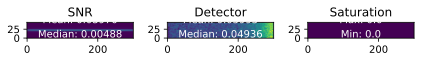

In [11]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(131)
ax2 = fig1.add_subplot(132)
ax3 = fig1.add_subplot(133)
ax1.imshow(results['2d']['snr'])
ax2.imshow(results['2d']['detector'])
ax3.imshow(results['2d']['saturation'])
ax1.set_title('SNR')
ax2.set_title('Detector')
ax3.set_title('Saturation')
ax1.text(0.5,0.95,'Mean: {0:6.5f}'.format(np.mean(results['2d']['snr'])),horizontalalignment='center',transform=ax1.transAxes,color='#FFFFFF')
ax1.text(0.5,0.05,'Median: {0:6.5f}'.format(np.median(results['2d']['snr'])),horizontalalignment='center',transform=ax1.transAxes,color='#FFFFFF')
ax2.text(0.5,0.95,'Mean: {0:6.5f}'.format(np.mean(results['2d']['detector'])),horizontalalignment='center',transform=ax2.transAxes,color='#FFFFFF')
ax2.text(0.5,0.05,'Median: {0:6.5f}'.format(np.median(results['2d']['detector'])),horizontalalignment='center',transform=ax2.transAxes,color='#FFFFFF')
ax3.text(0.5,0.95,'Max: {0:}'.format(np.max(results['2d']['saturation'])),horizontalalignment='center',transform=ax3.transAxes,color='#FFFFFF')
ax3.text(0.5,0.05,'Min: {0:}'.format(np.min(results['2d']['saturation'])),horizontalalignment='center',transform=ax3.transAxes,color='#FFFFFF')
fig1.tight_layout()

We can also see some 1D plots. They won't look like much in Imager mode.

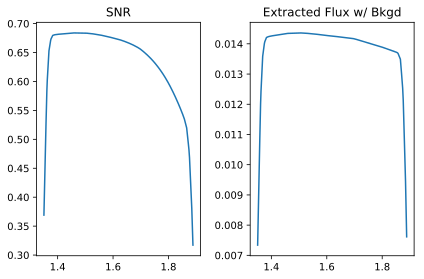

In [12]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(121)
ax2 = fig2.add_subplot(122)
if len(results['1d']['sn'][0]) == 1:
    ax1.scatter(results['1d']['sn'][0],results['1d']['sn'][1])
    ax2.scatter(results['1d']['extracted_flux_plus_bg'][0],results['1d']['extracted_flux_plus_bg'][1])
else:
    ax1.plot(results['1d']['sn'][0],results['1d']['sn'][1])
    ax2.plot(results['1d']['extracted_flux_plus_bg'][0],results['1d']['extracted_flux_plus_bg'][1])
ax1.set_title('SNR')
ax2.set_title('Extracted Flux w/ Bkgd')
fig2.tight_layout()

You can dump the calculation to a file (JSON format, which Python's json module can reconstruct into a dictionary) by running the following cell, and then copying the contents into a file.

In [13]:
print(json.dumps(calc, sort_keys=True, indent=4, separators=(',', ': ')))

{
    "background": "medium",
    "calculation": {
        "effects": {
            "background": true,
            "ipc": true,
            "saturation": true
        },
        "noise": {
            "crs": true,
            "darkcurrent": true,
            "ffnoise": true,
            "readnoise": true,
            "rn_correlation": true
        }
    },
    "configuration": {
        "detector": {
            "nexp": 1,
            "ngroup": 10,
            "nint": 1,
            "readmode": "deep2",
            "subarray": "full"
        },
        "dynamic_scene": true,
        "instrument": {
            "aperture": "grism",
            "disperser": "grsgrism",
            "filter": "grism",
            "instrument": "wfirstimager",
            "mode": "grism"
        },
        "max_scene_size": 25,
        "scene_size": 5
    },
    "scene": [
        {
            "position": {
                "orientation": 0.0,
                "position_parameters": [
                    "x

The saved file can be loaded back into a standalone Python instance (or Python script) and run through the engine.

For instance, if you saved your calculation to a file called input.json: